# Conectando com o Banco de Dados

In [3]:
import psycopg2
import os
import json
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

# Load the database parameters
db_params_path = os.path.join("scripts", "db_params.json")
with open(db_params_path, "r") as f:
    db_params = json.load(f)

# Establish a connection
connection = psycopg2.connect(**db_params)

## Teste

In [2]:
n = 0

# SQL query
sql_query = f"""SELECT problem_id, COUNT(DISTINCT user_id)
                FROM questions_userlog
                GROUP BY problem_id
                HAVING COUNT(DISTINCT user_id) >= {n};"""

# Load data into a Pandas dataframe
df = pd.read_sql_query(sql_query, connection)

# Take a look at the data
df.describe()

/var/folders/r4/lsk7h_t97_z0qpppcnz96n700000gn/T/ipykernel_12887/1497920074.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, connection)


,problem_id,count
count,138.000000,138.000000
mean,678.195652,369.673913
std,268.866718,539.780872
min,3.000000,1.000000
25%,743.250000,4.000000
50%,783.500000,20.000000
75%,818.750000,893.750000
max,857.000000,1813.000000


# Análise Exploratória

## Quantas questões existem no banco de dados?

In [3]:
# SQL query
sql_query = f"""SELECT *
                FROM questions_problem
                """

# Load data into a Pandas dataframe
questions_df = pd.read_sql_query(sql_query, connection)

# Count lines
questions_df.count()

/var/folders/r4/lsk7h_t97_z0qpppcnz96n700000gn/T/ipykernel_12887/593237104.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  questions_df = pd.read_sql_query(sql_query, connection)


id                     842
title                  842
content                842
difficulty             842
link                   842
retrieved_date         842
crawler                842
hint                   842
test_case_generator    124
question_type          842
options                842
dtype: int64

### Quantas questões com resposta existem no banco de dados?

In [4]:
n = 1

# SQL query
sql_query = f"""SELECT problem_id, COUNT(DISTINCT user_id)
                FROM questions_userlog
                GROUP BY problem_id
                HAVING COUNT(DISTINCT user_id) >= {n};"""

# Load data into a Pandas dataframe
df = pd.read_sql_query(sql_query, connection)

print(f"Number of problems with at least {n} answer(s) from distinct users: {len(df)}")

/var/folders/r4/lsk7h_t97_z0qpppcnz96n700000gn/T/ipykernel_12887/650427698.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, connection)


Number of problems with at least 1 answer(s) from distinct users: 138


## Quantas soluções existem no banco de dados?

Transformando tabela de soluções em Dataframe:

In [5]:
# SQL query
sql_query = f"""SELECT *
                FROM questions_userlog
                """

# Load data into a Pandas dataframe
solutions_df = pd.read_sql_query(sql_query, connection)

solutions_df.describe()


/var/folders/r4/lsk7h_t97_z0qpppcnz96n700000gn/T/ipykernel_12887/3692574933.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  solutions_df = pd.read_sql_query(sql_query, connection)


,id,seconds_in_code,seconds_in_page,seconds_to_begin,solution_lines,problem_id,user_id,test_case_hits,user_class_id
count,434337.000000,4.343370e+05,434337.000000,434337.000000,434337.000000,434337.000000,434337.000000,426418.000000,434337.000000
mean,351012.579948,8.547523e+02,2805.806567,335.728480,11.139997,803.728800,1843.444443,26.622722,69.952010
std,125402.352557,8.804527e+03,12750.494749,3536.405048,9.153649,52.135296,632.069444,39.219658,27.920784
min,84420.000000,0.000000e+00,0.000000,0.000000,1.000000,3.000000,1.000000,0.000000,2.000000
25%,242438.000000,9.200000e+01,314.000000,3.000000,7.000000,804.000000,1323.000000,0.000000,54.000000
50%,351023.000000,1.940000e+02,796.000000,15.000000,10.000000,813.000000,1762.000000,0.000000,73.000000
75%,459607.000000,3.900000e+02,1885.000000,79.000000,14.000000,827.000000,2348.000000,53.000000,88.000000
max,568191.000000,1.042544e+06,504133.000000,499615.000000,3859.000000,857.000000,3421.000000,100.000000,143.000000


In [6]:
solutions_count = len(solutions_df)
print(f"Number of solutions: {solutions_count}")

Number of solutions: 434337


Comparando corretas e incorretas (P = Passou, F = Falhou, S = ??):

In [7]:
solutions_df['outcome'].value_counts()

outcome
F    361533
P     64978
S      7826
Name: count, dtype: int64

## Quantas são as soluções sem contar as tentativas repetidas em cada questão?

Contamos apenas a última solução submetida por um usuário para cada questão.

Em outras palavras, queremos o número de soluções com pares únicos de [problem_id, user_id].

In [8]:
# Count number of solutions with unique problem_id/user_id pairs 

unique_solutions_count = len(solutions_df.groupby(["problem_id", "user_id"]))
print(f"Number of unique solutions: {unique_solutions_count}")
percentage = round(unique_solutions_count/solutions_count * 100, 1)
print(f"Counting only unique solutions, we need look just at {percentage}% of the solutions.")

Number of unique solutions: 51015
Counting only unique solutions, we need look just at 11.7% of the solutions.


## Quais são as estatísticas das soluções únicas?

Gerando um dataframe de soluções únicas

In [9]:
# Sort the solutions dataframe by 'user_id' and 'problem_id' and 'timestamp' in descending order
sorted_solutions_df = solutions_df.sort_values(by=['user_id', 'problem_id', 'timestamp'], ascending=[True, True, True])

# Use groupby to group by 'user_id' and 'problem_id' and select the last solution in each group
last_solution_df = sorted_solutions_df.groupby(['user_id', 'problem_id']).last().reset_index()

In [10]:
last_solution_df.describe()

,user_id,problem_id,id,seconds_in_code,seconds_in_page,seconds_to_begin,solution_lines,test_case_hits,user_class_id
count,51015.000000,51015.000000,51015.000000,51015.000000,51015.000000,51015.000000,51015.000000,50029.000000,51015.000000
mean,1829.338528,799.172734,351632.839655,506.568735,1785.642635,334.944036,11.333392,93.099083,69.161756
std,656.720386,63.597801,128877.753572,7900.330112,10297.295393,4604.079000,6.793658,24.535300,29.301950
min,1.000000,3.000000,84427.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
25%,1266.000000,800.000000,235979.500000,42.000000,137.000000,3.000000,7.000000,100.000000,38.000000
50%,1715.000000,815.000000,351300.000000,126.000000,443.000000,13.000000,10.000000,100.000000,73.000000
75%,2355.000000,828.000000,464049.000000,251.000000,1150.000000,65.000000,14.000000,100.000000,88.000000
max,3421.000000,857.000000,568191.000000,940115.000000,504133.000000,499615.000000,123.000000,100.000000,143.000000


Comparando corretas e incorretas (P = Passou, F = Falhou, S = ??):

In [11]:
last_solution_df['outcome'].value_counts()

outcome
P    45495
F     3320
S     2200
Name: count, dtype: int64

#

## Quantos são os alunos no banco de dados?

In [12]:
# TODO cortar os usuarios que são staff ou não estao ativos

# SQL query
sql_query = f"""SELECT id
                FROM auth_user
                """

# Load data into a Pandas dataframe
students_df = pd.read_sql_query(sql_query, connection)

# Count lines
print(f"Number of users: {len(students_df)}")

Number of users: 3162


/var/folders/r4/lsk7h_t97_z0qpppcnz96n700000gn/T/ipykernel_12887/3031740989.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  students_df = pd.read_sql_query(sql_query, connection)


## Como é o histograma do número de soluções por questão?

In [13]:
sols_per_question = last_solution_df.groupby(['problem_id'])['id'].count()
print(f"Number of questions with solutions: {len(sols_per_question)}")

Number of questions with solutions: 138


Como queremos apenas as questões que possuem pelo menos 2 soluções, vamos retirar aquelas que possuem apenas 1 solução:

In [14]:
sols_per_question = sols_per_question[sols_per_question > 1]
print(f"Number of questions with more than one solution: {len(sols_per_question)}")

Number of questions with more than one solution: 124


### Histograma Original

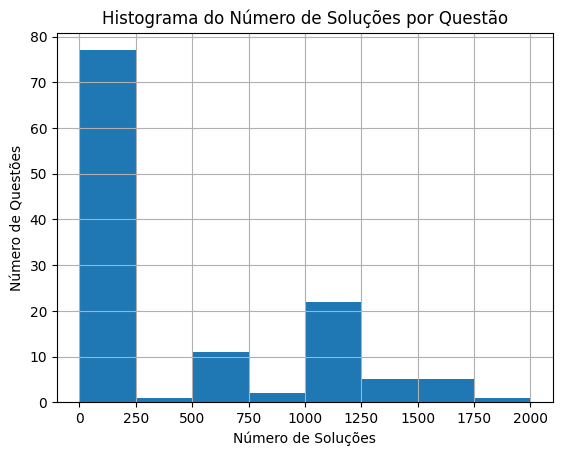

In [15]:
sols_per_question.hist(bins=range(0, 2001, 250))

# Add labels and a title
plt.xlabel('Número de Soluções')
plt.ylabel('Número de Questões')
plt.title('Histograma do Número de Soluções por Questão')

# Show the histogram
plt.show()

In [16]:
sols_per_question.describe()

count     124.000000
mean      411.298387
std       554.354939
min         2.000000
25%         6.000000
50%        23.500000
75%      1013.500000
max      1813.000000
Name: id, dtype: float64

### Avaliando questões com poucas soluções (<= 50)

Number of questions with less than 250 solutions: 77


Text(0.5, 1.0, 'Histograma Soluções por Questão (< 250 soluções)')

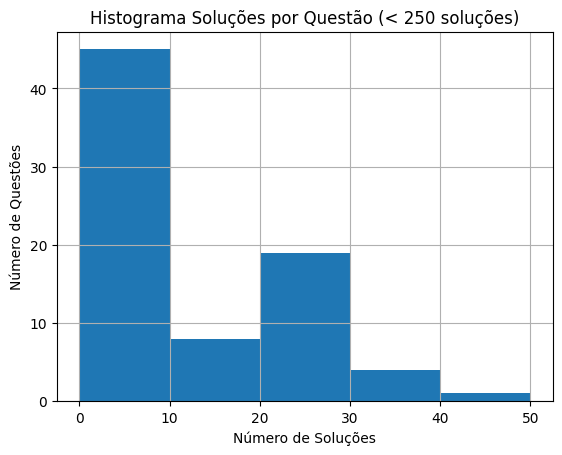

In [17]:
few_sols_series = sols_per_question[sols_per_question < 250]
few_sols_series.hist(bins=range(0, 51, 10))

print(f"Number of questions with less than 250 solutions: {len(few_sols_series)}")

# Add labels and a title
plt.xlabel('Número de Soluções')
plt.ylabel('Número de Questões')
plt.title('Histograma Soluções por Questão (< 250 soluções)')

In [19]:
few_sols_series.describe()

count    77.000000
mean     12.467532
std      10.665469
min       2.000000
25%       4.000000
50%       7.000000
75%      21.000000
max      50.000000
Name: id, dtype: float64

### Avaliando questões com muitas soluções (> 250)

Number of questions with more than 250 solutions: 47


Text(0.5, 1.0, 'Histograma Soluções por Questão (> 250 soluções)')

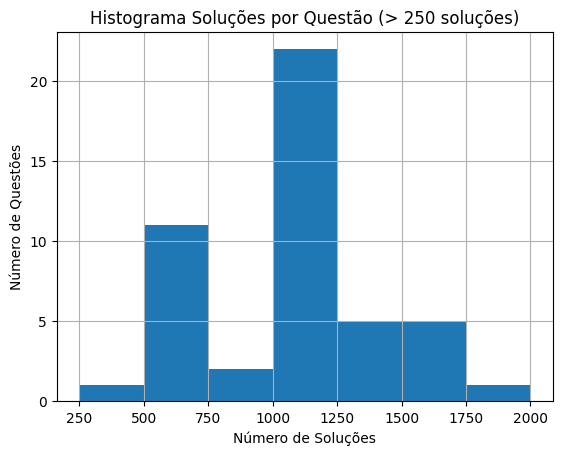

In [18]:
many_sols_series = sols_per_question[sols_per_question > 250]
many_sols_series.hist(bins=range(250, 2001, 250))

print(f"Number of questions with more than 250 solutions: {len(many_sols_series)}")

# Add labels and a title
plt.xlabel('Número de Soluções')
plt.ylabel('Número de Questões')
plt.title('Histograma Soluções por Questão (> 250 soluções)')

In [65]:
many_sols_series.describe()

count      47.000000
mean     1064.702128
std       345.036603
min       492.000000
25%       824.500000
50%      1065.000000
75%      1245.000000
max      1813.000000
Name: id, dtype: float64

# Análise dos Dados do Overcode

## Teste com Problema Individual

### Coletar dados do Machine Teaching e processar com Overcode

In [25]:
from master_script import run_master_script

problems_with_error = []

for problem_id in few_sols_series.index:
  try:
    run_master_script(problem_id, interface=False)
  except:
    problems_with_error.append(problem_id)

print(f"Problems with error during master script execution: {problems_with_error}")

Master Script finished running for problem 12.
Master Script finished running for problem 730.
Master Script finished running for problem 732.
Master Script finished running for problem 759.
Master Script finished running for problem 763.
Master Script finished running for problem 764.
Master Script finished running for problem 769.
Master Script finished running for problem 772.
Master Script finished running for problem 774.
Master Script finished running for problem 776.
Master Script finished running for problem 778.
Master Script finished running for problem 786.
Master Script finished running for problem 787.
Master Script finished running for problem 788.
Master Script finished running for problem 789.
Master Script finished running for problem 844.
Master Script finished running for problem 845.
Master Script finished running for problem 846.
Master Script finished running for problem 847.
Master Script finished running for problem 856.
Problems with error during master script 

In [1]:
from master_script import run_master_script

problem_id = 778

run_master_script(problem_id, interface=False)

removing:  print(sum([A for A in range(int(input("3")), int(input("7")) + 1) if A % 2 == 0]))
expected ':' (python_minifier.minify source, line 1)
Running logger on 2214
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

0.4576950000000002
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

0.46266000000000007
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

0.4678810000000002
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

0.471627
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

0.4768450000000002
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

0.4801770000000001
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

0.48321800000000015
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

0.4887730000000001
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

0.4950420000000002
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

0.4994740000000002
Running logger on answer
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,

### Analisar output do Overcode

In [4]:
df_test = pd.read_json(f"problems_data/problem_{problem_id}/output/solutions.json")
df_test.head()

,correct,count,error_vector,id,lineIDs,lines,members,num_passed_tests,number,phraseIDs,stack_distances,test_input_outputs,testcases,total_num_tests,variableIDs
0,True,1,"[True, True, True, True, True, True, True, Tru...",1,"{'list': [1, 2, 3, 4, 5], 'type': 'set'}","[{'indent': 0, 'line_obj_ID': 1, 'phraseID': 1...",[1],10,1,"[1, 2, 3, 4, 5]","{'1': 1.0, '2': 0.392857142857142, '3': 0.0, '...","{'print(soma_impar(106))': '11236 ', 'print(so...","[print(soma_impar(123)), print(soma_impar(123)...",10,"[1, 2, 3]"
1,True,1,"[True, True, True, True, True, True, True, Tru...",2,"{'list': [1, 6], 'type': 'set'}","[{'indent': 0, 'line_obj_ID': 1, 'phraseID': 1...",[2666],10,2666,"[1, 6]","{'1': 0.392857142857142, '2': 1.0, '3': 0.0, '...","{'print(soma_impar(106))': '11236 ', 'print(so...","[print(soma_impar(123)), print(soma_impar(123)...",10,[2]
2,False,1,"[False, False, False, False, False, False, Fal...",3,"{'list': [], 'type': 'set'}",[],[2921],0,2921,[],"{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...","{'print(soma_impar(106))': '', 'print(soma_imp...","[print(soma_impar(123)), print(soma_impar(123)...",10,[]
3,False,1,"[False, False, False, False, False, False, Fal...",4,"{'list': [], 'type': 'set'}",[],[1029],0,1029,[],"{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...","{'print(soma_impar(106))': '', 'print(soma_imp...","[print(soma_impar(123)), print(soma_impar(123)...",10,[]
4,False,1,"[False, False, False, False, False, False, Fal...",5,"{'list': [], 'type': 'set'}",[],[2214],0,2214,[],"{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...","{'print(soma_impar(106))': '', 'print(soma_imp...","[print(soma_impar(123)), print(soma_impar(123)...",10,[]


#### Quantidade de Soluções e Soluções Corretas

In [5]:
total_solutions = sum(df_test['count'])
print(f"Number of solutions: {total_solutions}")
correct_solutions = df_test[df_test['correct'] == True]['count'].sum()
print(f"Number of correct solutions: {correct_solutions}")
print(f"Number of incorrect solutions: {total_solutions - correct_solutions}")

Number of solutions: 5
Number of correct solutions: 2
Number of incorrect solutions: 3


#### Quantidade de Clusters

In [6]:
total_clusters = len(df_test)
print(f"Number of clusters: {total_clusters}")

correct_clusters = len(df_test[df_test['correct'] == True])
print(f"Number of correct clusters: {correct_clusters}")
print(f"Number of incorrect clusters: {total_clusters - correct_clusters}")

Number of clusters: 5
Number of correct clusters: 2
Number of incorrect clusters: 3


#### Redução da Quantidade de Códigos a serem analisados:

In [7]:
sols_percentage = round(len(df_test)/total_solutions * 100, 1)
print(f"Using Overcode, we only need to read {sols_percentage}% of the solutions to understand the problem.")

Using Overcode, we only need to read 100.0% of the solutions to understand the problem.


#### Histograma dos clusters de soluções

Text(0.5, 1.0, 'Histograma Soluções X Cluster')

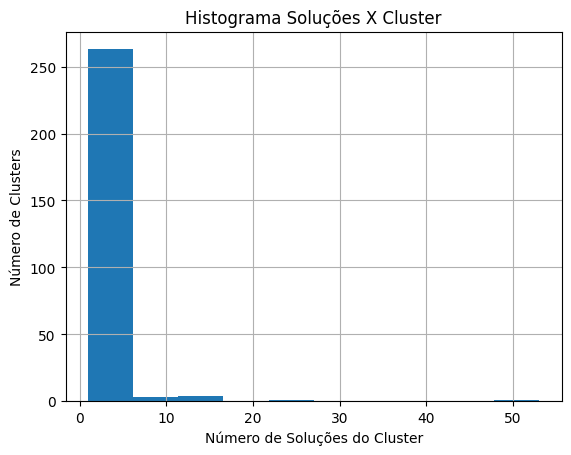

In [75]:
df_test['count'].hist()
# Add labels and a title
plt.xlabel('Número de Soluções do Cluster')
plt.ylabel('Número de Clusters')
plt.title('Histograma Soluções X Cluster')

#### Verificação da Regra de Pareto

Ordenar os clusters do maior para o menor

In [76]:
sorted_df = df_test['count'].sort_values(ascending=False)
sorted_df.head()

6     53
24    25
5     15
8     14
0     13
Name: count, dtype: int64

Calcular quanto é 20% do total de clusters e qual porcentagem de soluções atingimos com esses 20%

In [79]:
twenty_percent = round(total_clusters * 0.2)
print(f"With 20% ({twenty_percent}) of the {total_clusters} clusters,")

represented_solutions = sorted_df[:twenty_percent].sum()
percentage = round(represented_solutions/total_solutions * 100, 1)
print(f"we get {percentage}% ({represented_solutions}) of the {total_solutions} solutions")

With 20% (54) of the 272 clusters,
we get 55.1% (267) of the 485 solutions


O Inverso: Calcular quanto é 80% do total de soluções e quantos clusters precisamos para atingir esses 80%

In [54]:
eighty_percent = round(total_solutions * 0.8)

for i in range(1, len(sorted_df)):
    if sorted_df[:i].sum() >= eighty_percent:
        break

inverse_percentage = round(i/total_clusters * 100, 1)
print(f"We need {inverse_percentage}% ({i}) clusters to represent 80% ({eighty_percent}) of the solutions.")

We need 72.7% (282) clusters to represent 80% (422) of the solutions.
